# Example 2: Falling Ball

To illustrate how to use `calibrator` class, we will use the data set in [Example 1] of a falling ball. 

First, import the main libraries we use for this example.

In [1]:
import numpy as np
import scipy.stats as sps
import sys
import os
import copy
import matplotlib.pyplot as plt 
from scipy.stats import kde

current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.emulation import emulator
from base.calibration import calibrator

We collect the data at two different heights 25 and 50.

In [2]:
x = np.array([[ 0.1, 25. ],
              [ 0.2, 25. ],
              [ 0.3, 25. ],
              [ 0.4, 25. ],
              [ 0.5, 25. ],
              [ 0.6, 25. ],
              [ 0.7, 25. ],
              [ 0.9, 25. ],
              [ 1.1, 25. ],
              [ 1.3, 25. ],
              [ 2.0, 25. ],
              [ 2.4, 25. ],
              [ 0.1, 50. ],
              [ 0.2, 50. ],
              [ 0.3, 50. ],
              [ 0.4, 50. ],
              [ 0.5, 50. ],
              [ 0.6, 50. ],
              [ 0.7, 50. ],
              [ 0.8, 50. ],
              [ 0.9, 50. ],
              [ 1.0, 50. ],
              [ 1.2, 50. ],
              [ 3.5, 50. ],
              [ 3.7, 50. ],
              [ 2.6, 50. ],
              [ 2.9, 50. ],
              [ 3.1, 50. ],
              [ 3.3, 50. ],]).astype('object')

In [3]:
def balldroptrue(x):
    """Place description here."""
    def logcosh(x):
        # preventing crashing
        s = np.sign(x) * x
        p = np.exp(-2 * s)
        return s + np.log1p(p) - np.log(2)
    t = x[:, 0]
    h0 = x[:, 1]
    vter = 20
    g = 9.81
    y = h0 - (vter ** 2) / g * logcosh(g * t / vter)
    return y

In [4]:
xv = x.astype('float')

# variance for the observations in 'y' below
obsvar = 4*np.ones(x.shape[0])  

#observations at each row of 'x'
y = balldroptrue(xv) + sps.norm.rvs(0, np.sqrt(obsvar)) 

print(np.shape(y))

x[x[:,1] == 25, 1] = 'lowdrop'
x[x[:,1] == 50, 1] = 'highdrop'

(29,)


## Building an emulator

Recall the computer model experiments and the prior distributions from [Example 1].

In [5]:
def balldropmodel_linear(x, theta):
    """Place description here."""
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1] + theta[k, 0]
        vter = theta[k, 1]
        f[k, :] = h0 - vter * t
    return f.T

def balldropmodel_grav(x, theta):
    """Place description here."""
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k]
        f[k, :] = h0 - (g / 2) * (t ** 2)
    return f.T

class priorphys_lin:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return np.squeeze(sps.norm.logpdf(theta[:, 0], 0, 5) +  # initial height deviation
                          sps.gamma.logpdf(theta[:, 1], 2, 0, 10))   # terminal velocity

    def rnd(n):
        return np.vstack((sps.norm.rvs(0, 5, size=n),  # initial height deviation
                          sps.gamma.rvs(2, 0, 10, size=n))).T  # terminal velocity

class priorphys_grav:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return np.squeeze(sps.gamma.logpdf(theta, 2, 0, 5))  # gravity

    def rnd(n):
        return np.reshape(sps.gamma.rvs(2, 0, 5, size=n), (-1,1))  # gravity

In [6]:
 # the time vector of interest
tvec = np.concatenate((np.arange(0.1, 4.3, 0.1), np.arange(0.1, 4.3, 0.1))) 

# the drop heights vector of interest
hvec = np.concatenate((25 * np.ones(42), 50 * np.ones(42)))  

# the input of interest
xtot = (np.vstack((tvec, hvec)).T).astype('object')  
xtotv = xtot.astype('float')
xtot[xtot[:,1] == 25, 1] = 'lowdrop'
xtot[xtot[:,1] == 50, 1] = 'highdrop'

# draw 50 random parameters from the prior
thetacompexp_lin = priorphys_lin.rnd(50) 

# draw 50 random parameters from the prior
thetacompexp_grav = priorphys_grav.rnd(50)  

# create a computer experiment to build an emulator for the linear simulation
lin_results = balldropmodel_linear(xtotv, thetacompexp_lin)

# create a computer experiment to build an emulator for the gravity simulation
grav_results = balldropmodel_grav(xtotv, thetacompexp_grav)  

# build an emulator for the linear simulation
emu_lin = emulator(xtot, thetacompexp_lin, lin_results, method = 'PCGPwM') 

# build an emulator for the gravity simulation
emu_grav = emulator(xtot, thetacompexp_grav, grav_results, method = 'PCGPwM')  

## Building a calibrator

### Calibrators for a linear model

In [7]:
cal_lin = calibrator(emu_lin, y, x, thetaprior = priorphys_lin, 
                     method = 'directbayes', 
                     yvar = obsvar)

We have received some non-finite values from emulation.
It looks like some locations are ok.
Current protocol is to remove observations that have nonfinite values.
Removing values at [ 2  6  9 11 14 18 22 23 26 28].


ValueError: operands could not be broadcast together with shapes (19,) (84,) 

In [7]:
cal_lin_1 = calibrator(emu = emu_lin, y = y, x = x, thetaprior = priorphys_lin, 
                       method = 'MLcal', yvar = obsvar, 
                       args = {'theta0': np.array([0, 9]), 
                               'numsamp' : 1000, 
                               'stepType' : 'normal', 
                               'stepParam' : np.array([0.1, 1])})
                   

We have received some non-finite values from emulation.
It looks like some locations are ok.
Current protocol is to remove observations that have nonfinite values.
Removing values at [ 2  6  9 11 14 18 22 23 26 28].
n_acc rate= 0.336


Now, we build a calibrator using a different sampler `plumlee`.

In [8]:
cal_lin_2 = calibrator(emu = emu_lin, y = y, x = x, thetaprior = priorphys_lin, 
                       method = 'MLcal', yvar = obsvar, 
                       args = {'sampler' : 'plumlee'})

We have received some non-finite values from emulation.
It looks like some locations are ok.
Current protocol is to remove observations that have nonfinite values.
Removing values at [ 2  6  9 11 14 18 22 23 26 28].


In [9]:
# get a prediction object
pred_lin_1 = cal_lin_1.predict(xtot)
pred_lin_2 = cal_lin_2.predict(xtot)

In [ ]:
def two2d(axis, theta):
    nbins = 50
    k = kde.gaussian_kde(theta.T)
    xi, yi = np.mgrid[-10:10:nbins*1j, 0:20:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    axis.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
    axis.contour(xi, yi, zi.reshape(xi.shape))

In [10]:
def plotpreds(axis, pred):
    preds = pred.rnd(1000)
    for k in (25,50):
        inds = np.where(xtotv[:,1] == k)[0]
        for l in range(0,1000):
            axis.plot(xtotv[inds,0],preds[l, inds],'k-', alpha=0.01,linewidth=0.1)
        uppercurve = np.quantile(preds[:, inds],0.975,0)
        lowercurve = np.quantile(preds[:, inds],0.025,0)
        p4 = axis.plot(xtotv[inds,0], balldroptrue(xtotv[inds,:]), 'k--',linewidth=2)
        axis.fill_between(xtotv[inds,0], lowercurve, uppercurve, color='k', alpha=0.25)
    p1 = axis.plot(np.NaN, np.NaN, color='k', linewidth=3)
    p2 = axis.fill(np.NaN, np.NaN, 'k', alpha=0.5)
    p3 = axis.plot(xv,y, 'ro' ,markersize = 8)
    axis.set_xlim([0,4.2])
    axis.set_ylim([-5,55])
    axis.set_xlabel('time')
    axis.set_ylabel('distance')
    axis.legend([p4[0],(p2[0], p1[0]), p3[0]], ['truth','prediction','observations'])

Text(0.5, 1.0, 'prediction using gravity model')

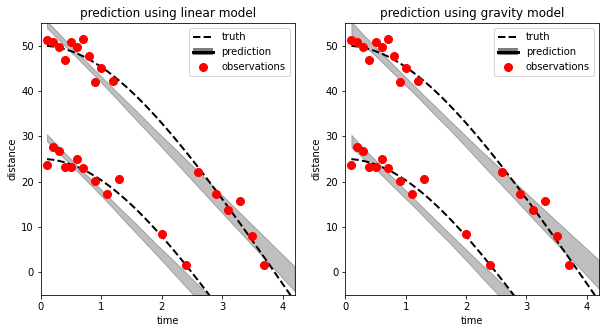

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
plotpreds(axes[0], pred_lin_1)
axes[0].set_title('prediction using linear model')
plotpreds(axes[1], pred_lin_2)
axes[1].set_title('prediction using gravity model')